## 1. Setup & Configuration

In [25]:
"""Deep Learning Models for Kidney CT Classification"""

import os
import json
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import timm

# Dynamic device selection: CUDA > MPS > CPU
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
USE_CUDA = device.type == 'cuda'
USE_MPS = device.type == 'mps'

# CUDA-specific optimizations
if USE_CUDA:
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"Device: {device}")
if USE_CUDA:
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")
elif USE_MPS:
    print("Using Apple Silicon GPU (MPS)")

Device: cuda
GPU: NVIDIA GeForce RTX 3090 Ti
VRAM: 25.76 GB


In [ ]:
# Load dataset configuration
CONFIG_PATH = '../data/dataset_config.json'
assert os.path.exists(CONFIG_PATH), "Run 01_data_analysis_processing.ipynb first!"

with open(CONFIG_PATH) as f:
    config = json.load(f)

DATA_PATH = config['data_path']
MEAN, STD = config['mean'], config['std']
IMAGE_SIZE = config['image_size']

# Shared hyperparameters
BATCH_SIZE = 128
LR = 1e-3
SEED = 42
OUTPUT_BASE = '../outputs/dl'

torch.manual_seed(SEED)
if USE_CUDA:
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(f"Data: {DATA_PATH}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Normalization - Mean: {[f'{m:.4f}' for m in MEAN]}, Std: {[f'{s:.4f}' for s in STD]}")

Data: c:\Users\ELJOE\Desktop\masters\machine\project\data\processed
Image Size: 224
Normalization - Mean: ['0.1451', '0.1451', '0.1451'], Std: ['0.2177', '0.2177', '0.2177']


## 2. Dataset Loading (Cached in RAM)

In [27]:
class CachedTensorDataset(torch.utils.data.Dataset):
    """Dataset that caches all images as tensors in RAM for fast training."""
    def __init__(self, root, augment=False):
        dataset = datasets.ImageFolder(root)
        self.augment = augment
        self.targets = []
        self.tensors = []
        
        print(f"Caching {len(dataset)} images as tensors...")
        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])
        
        for path, target in tqdm(dataset.samples, desc="Loading"):
            img = Image.open(path).convert('RGB')
            tensor = transform(img)
            self.tensors.append(tensor)
            self.targets.append(target)
        
        self.tensors = torch.stack(self.tensors)
        self.targets = torch.tensor(self.targets)
        self.classes = dataset.classes
        print(f"Cached tensor shape: {self.tensors.shape}")
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        x = self.tensors[idx]
        if self.augment:
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [2])  # Horizontal flip
            if torch.rand(1) > 0.5:
                x = torch.flip(x, [1])  # Vertical flip
        return x, self.targets[idx]

# Load datasets once
train_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'train'), augment=True)
test_dataset = CachedTensorDataset(os.path.join(DATA_PATH, 'test'), augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False,
                         num_workers=0, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"\nClasses: {class_names}")
print(f"Train: {len(train_dataset):,} | Test: {len(test_dataset):,}")

Caching 9411 images as tensors...


Loading: 100%|██████████| 9411/9411 [00:22<00:00, 423.82it/s]


Cached tensor shape: torch.Size([9411, 3, 224, 224])
Caching 4034 images as tensors...


Loading: 100%|██████████| 4034/4034 [00:11<00:00, 347.25it/s]


Cached tensor shape: torch.Size([4034, 3, 224, 224])

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Train: 9,411 | Test: 4,034


## 3. Model Architectures

In [28]:
# =====================================================
# Model 1: EfficientNet-B0 (Transfer Learning)
# =====================================================
class EfficientNetClassifier(nn.Module):
    """EfficientNet-B0 with frozen backbone and trainable classifier."""
    def __init__(self, num_classes, freeze_backbone=True):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.classifier(self.backbone(x))

# =====================================================
# Model 2: ResNet-50 (Transfer Learning)
# =====================================================
def create_resnet50(num_classes, freeze_backbone=True):
    """ResNet-50 with frozen backbone and trainable classifier."""
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

# =====================================================
# Model 3: DenseNet-121 (Transfer Learning)
# =====================================================
def create_densenet121(num_classes, freeze_backbone=True):
    """DenseNet-121 with frozen backbone and trainable classifier."""
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

# =====================================================
# Model 4: Custom CNN (From Scratch)
# =====================================================
class SimpleCNN(nn.Module):
    """
    4-stage CNN with progressive channel expansion.
    Architecture: 3→32→64→128→256 channels with spatial reduction at each stage.
    """
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.features = nn.Sequential(
            # Stage 1: 224→112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Stage 2: 112→56
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Stage 3: 56→28
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Stage 4: 28→14
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )
        
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).flatten(1)
        return self.classifier(x)

print("Model architectures defined:")
print("  1. EfficientNet-B0 (timm, frozen backbone)")
print("  2. ResNet-50 (torchvision, frozen backbone)")
print("  3. DenseNet-121 (torchvision, frozen backbone)")
print("  4. SimpleCNN (custom, trained from scratch)")

Model architectures defined:
  1. EfficientNet-B0 (timm, frozen backbone)
  2. ResNet-50 (torchvision, frozen backbone)
  3. DenseNet-121 (torchvision, frozen backbone)
  4. SimpleCNN (custom, trained from scratch)


## 4. Training & Evaluation Functions

In [29]:
# Mixed precision setup
scaler = torch.amp.GradScaler(device.type) if USE_CUDA else None
amp_dtype = torch.float16 if USE_CUDA else torch.float32

def train_epoch(model, loader, criterion, optimizer, scheduler=None, step_per_batch=False):
    """Train for one epoch."""
    model.train()
    loss_sum, correct, total = 0, 0, 0
    
    for images, labels in tqdm(loader, desc='Train', leave=False):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        optimizer.zero_grad(set_to_none=True)
        
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        
        if scheduler and step_per_batch:
            scheduler.step()
        
        loss_sum += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate(model, loader):
    """Evaluate model on a dataset."""
    model.eval()
    all_preds, all_labels = [], []
    
    for images, labels in tqdm(loader, desc='Eval', leave=False):
        images = images.to(device, non_blocking=True)
        
        with torch.amp.autocast(device.type, dtype=amp_dtype, enabled=USE_CUDA):
            preds = model(images).argmax(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

def train_model(model, model_name, epochs, use_onecycle=False):
    """Complete training pipeline for a model."""
    output_dir = os.path.join(OUTPUT_BASE, model_name.lower().replace('-', '').replace(' ', '_'))
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, 'model.pth')
    
    # Count parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    print(f"Trainable params: {trainable_params:,} / {total_params:,}")
    print(f"Epochs: {epochs}")
    
    # Setup optimizer and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                            lr=LR, weight_decay=1e-4)
    
    if use_onecycle:
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=len(train_loader))
        step_per_batch = True
    else:
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        step_per_batch = False
    
    # Training loop
    history = {'train_loss': [], 'train_acc': []}
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, step_per_batch)
        
        if not step_per_batch:
            scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    
    # Save model
    torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names}, model_path)
    print(f"Model saved to {model_path}")
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(history['train_loss'], color='#3498db')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Training Loss')
    
    ax2.plot(history['train_acc'], color='#2ecc71')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} - Training Accuracy')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    # Test evaluation
    print(f"\nEvaluating on test set...")
    test_preds, test_labels = evaluate(model, test_loader)
    test_acc = (test_preds == test_labels).mean()
    
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(classification_report(test_labels, test_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=150)
    plt.show()
    
    # Save results
    results = {
        'model_name': model_name,
        'test_accuracy': float(test_acc),
        'trainable_params': trainable_params,
        'total_params': total_params,
        'epochs': epochs
    }
    
    with open(os.path.join(output_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    return results

def clear_gpu_memory():
    """Clear GPU memory between models."""
    gc.collect()
    if USE_CUDA:
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print("Training functions defined.")

Training functions defined.


---
## 5. Train EfficientNet-B0
Transfer learning with frozen ImageNet backbone (timm library)


Training: EfficientNet-B0
Trainable params: 328,964 / 4,336,512
Epochs: 20


Epoch 01/20 | Loss: 0.4988 | Acc: 0.8103


Epoch 02/20 | Loss: 0.2061 | Acc: 0.9289


Epoch 03/20 | Loss: 0.1492 | Acc: 0.9477


Epoch 04/20 | Loss: 0.1184 | Acc: 0.9608


Epoch 05/20 | Loss: 0.0919 | Acc: 0.9683


Epoch 06/20 | Loss: 0.0723 | Acc: 0.9762


Epoch 07/20 | Loss: 0.0658 | Acc: 0.9801


Epoch 08/20 | Loss: 0.0575 | Acc: 0.9822


Epoch 09/20 | Loss: 0.0444 | Acc: 0.9878


Epoch 10/20 | Loss: 0.0432 | Acc: 0.9869


Epoch 11/20 | Loss: 0.0390 | Acc: 0.9890


Epoch 12/20 | Loss: 0.0335 | Acc: 0.9907


Epoch 13/20 | Loss: 0.0303 | Acc: 0.9913


Epoch 14/20 | Loss: 0.0256 | Acc: 0.9933


Epoch 15/20 | Loss: 0.0239 | Acc: 0.9943


Epoch 16/20 | Loss: 0.0227 | Acc: 0.9945


Epoch 17/20 | Loss: 0.0239 | Acc: 0.9948


Epoch 18/20 | Loss: 0.0219 | Acc: 0.9942


Epoch 19/20 | Loss: 0.0219 | Acc: 0.9953


Epoch 20/20 | Loss: 0.0222 | Acc: 0.9948
Model saved to ../outputs\efficientnetb0\model.pth


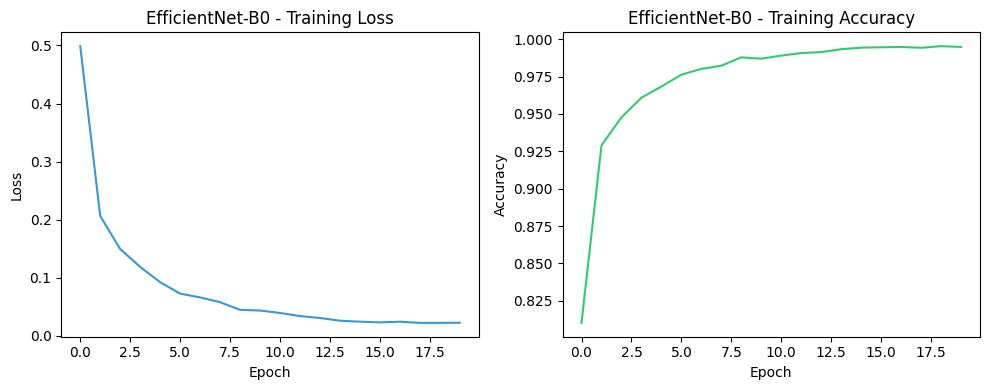


Evaluating on test set...



Test Accuracy: 0.9916
              precision    recall  f1-score   support

        Cyst       0.99      0.99      0.99       985
      Normal       0.99      1.00      1.00      1501
       Stone       0.99      0.98      0.99       863
       Tumor       0.99      0.99      0.99       685

    accuracy                           0.99      4034
   macro avg       0.99      0.99      0.99      4034
weighted avg       0.99      0.99      0.99      4034



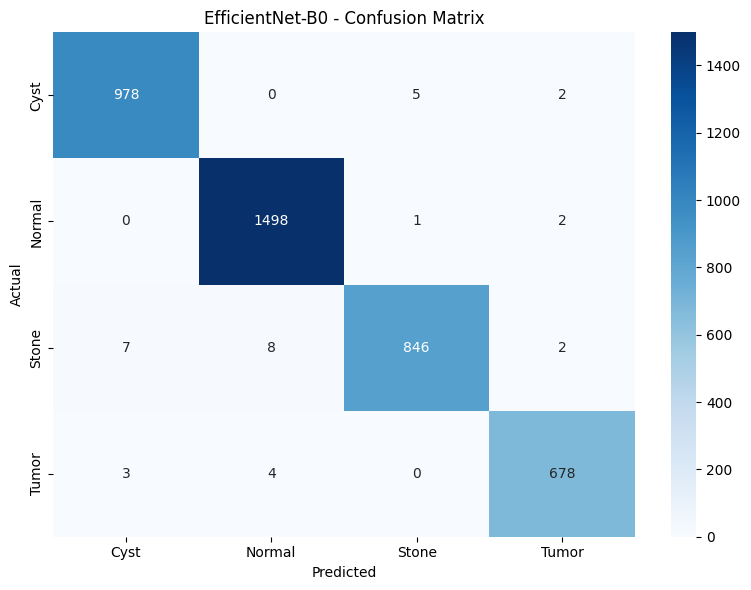

In [30]:
clear_gpu_memory()

efficientnet_model = EfficientNetClassifier(num_classes).to(device)
efficientnet_results = train_model(efficientnet_model, 'EfficientNet-B0', epochs=20)

del efficientnet_model
clear_gpu_memory()

---
## 6. Train ResNet-50
Transfer learning with frozen ImageNet backbone (torchvision)


Training: ResNet-50
Trainable params: 525,572 / 24,033,604
Epochs: 20


Epoch 01/20 | Loss: 0.7003 | Acc: 0.7378


Epoch 02/20 | Loss: 0.3549 | Acc: 0.8794


Epoch 03/20 | Loss: 0.2662 | Acc: 0.9098


Epoch 04/20 | Loss: 0.2220 | Acc: 0.9234


Epoch 05/20 | Loss: 0.1878 | Acc: 0.9381


Epoch 06/20 | Loss: 0.1602 | Acc: 0.9442


Epoch 07/20 | Loss: 0.1419 | Acc: 0.9531


Epoch 08/20 | Loss: 0.1246 | Acc: 0.9574


Epoch 09/20 | Loss: 0.1104 | Acc: 0.9649


Epoch 10/20 | Loss: 0.1012 | Acc: 0.9668


Epoch 11/20 | Loss: 0.0943 | Acc: 0.9704


Epoch 12/20 | Loss: 0.0882 | Acc: 0.9721


Epoch 13/20 | Loss: 0.0849 | Acc: 0.9728


Epoch 14/20 | Loss: 0.0827 | Acc: 0.9740


Epoch 15/20 | Loss: 0.0757 | Acc: 0.9774


Epoch 16/20 | Loss: 0.0738 | Acc: 0.9769


Epoch 17/20 | Loss: 0.0699 | Acc: 0.9773


Epoch 18/20 | Loss: 0.0697 | Acc: 0.9807


Epoch 19/20 | Loss: 0.0680 | Acc: 0.9801


Epoch 20/20 | Loss: 0.0666 | Acc: 0.9796
Model saved to ../outputs\resnet50\model.pth


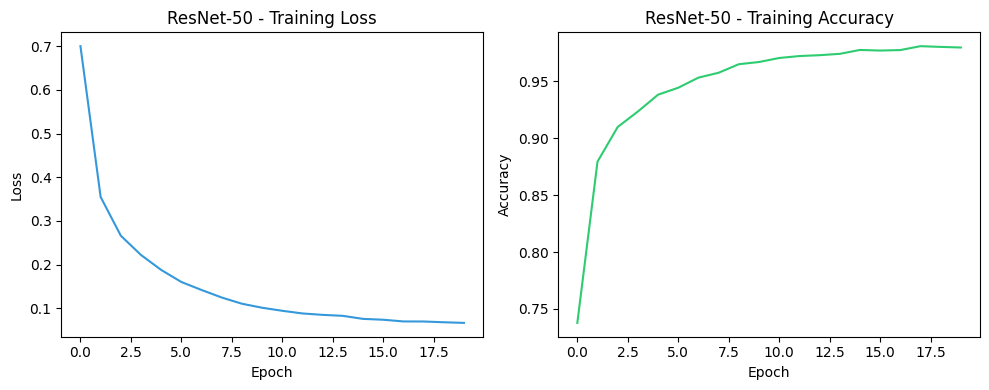


Evaluating on test set...



Test Accuracy: 0.9742
              precision    recall  f1-score   support

        Cyst       0.96      0.99      0.98       985
      Normal       0.98      0.98      0.98      1501
       Stone       0.99      0.94      0.96       863
       Tumor       0.97      0.98      0.97       685

    accuracy                           0.97      4034
   macro avg       0.97      0.97      0.97      4034
weighted avg       0.97      0.97      0.97      4034



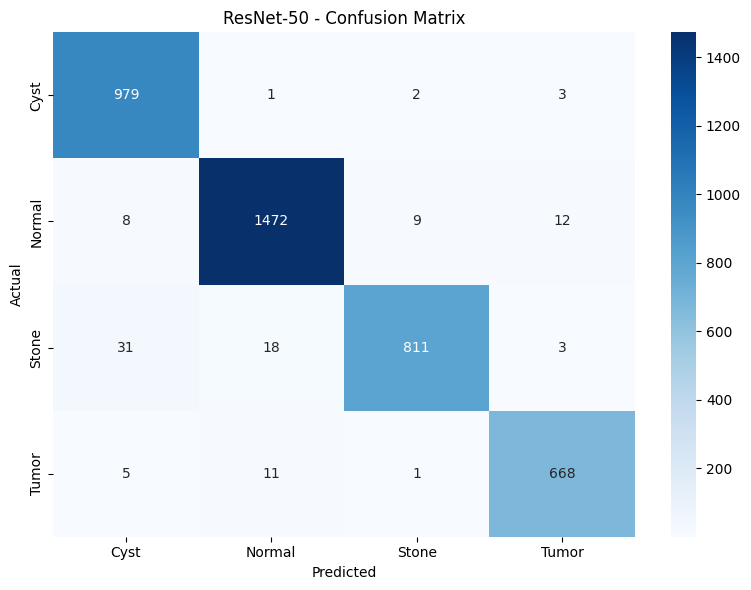

In [31]:
clear_gpu_memory()

resnet_model = create_resnet50(num_classes).to(device)
resnet_results = train_model(resnet_model, 'ResNet-50', epochs=20)

del resnet_model
clear_gpu_memory()

---
## 7. Train DenseNet-121
Transfer learning with frozen ImageNet backbone (torchvision)


Training: DenseNet-121
Trainable params: 263,428 / 7,217,284
Epochs: 20


Epoch 01/20 | Loss: 0.7761 | Acc: 0.7033


Epoch 02/20 | Loss: 0.4174 | Acc: 0.8510


Epoch 03/20 | Loss: 0.3317 | Acc: 0.8815


Epoch 04/20 | Loss: 0.2876 | Acc: 0.8970


Epoch 05/20 | Loss: 0.2516 | Acc: 0.9114


Epoch 06/20 | Loss: 0.2159 | Acc: 0.9241


Epoch 07/20 | Loss: 0.2128 | Acc: 0.9268


Epoch 08/20 | Loss: 0.1913 | Acc: 0.9319


Epoch 09/20 | Loss: 0.1740 | Acc: 0.9366


Epoch 10/20 | Loss: 0.1563 | Acc: 0.9453


Epoch 11/20 | Loss: 0.1575 | Acc: 0.9462


Epoch 12/20 | Loss: 0.1407 | Acc: 0.9525


Epoch 13/20 | Loss: 0.1297 | Acc: 0.9554


Epoch 14/20 | Loss: 0.1220 | Acc: 0.9597


Epoch 15/20 | Loss: 0.1261 | Acc: 0.9562


Epoch 16/20 | Loss: 0.1140 | Acc: 0.9613


Epoch 17/20 | Loss: 0.1069 | Acc: 0.9641


Epoch 18/20 | Loss: 0.1081 | Acc: 0.9654


Epoch 19/20 | Loss: 0.1066 | Acc: 0.9660


Epoch 20/20 | Loss: 0.1083 | Acc: 0.9641
Model saved to ../outputs\densenet121\model.pth


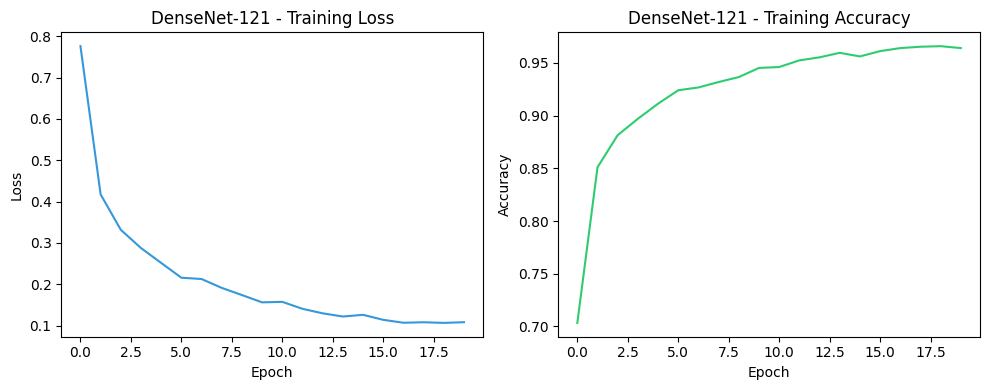


Evaluating on test set...



Test Accuracy: 0.9650
              precision    recall  f1-score   support

        Cyst       0.96      0.97      0.96       985
      Normal       0.97      0.99      0.98      1501
       Stone       0.96      0.93      0.95       863
       Tumor       0.97      0.94      0.96       685

    accuracy                           0.97      4034
   macro avg       0.96      0.96      0.96      4034
weighted avg       0.97      0.97      0.96      4034



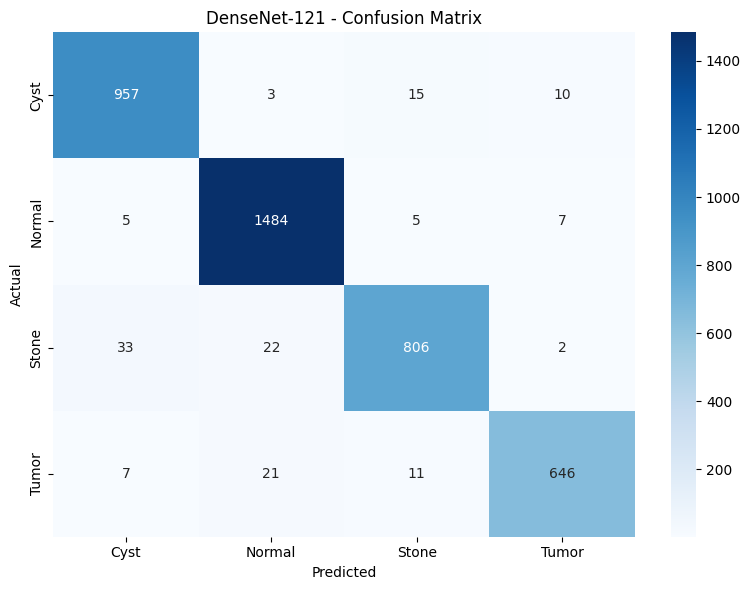

In [32]:
clear_gpu_memory()

densenet_model = create_densenet121(num_classes).to(device)
densenet_results = train_model(densenet_model, 'DenseNet-121', epochs=20)

del densenet_model
clear_gpu_memory()

---
## 8. Train Custom CNN
4-stage CNN trained from scratch with OneCycleLR scheduler


Training: Custom-CNN
Trainable params: 390,404 / 390,404
Epochs: 100


Train:   0%|          | 0/73 [00:00<?, ?it/s]C:\Users\ELJOE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 01/100 | Loss: 1.3480 | Acc: 0.3702


Epoch 02/100 | Loss: 1.1595 | Acc: 0.5073


Epoch 03/100 | Loss: 1.0681 | Acc: 0.5523


Epoch 04/100 | Loss: 1.0242 | Acc: 0.5864


Epoch 05/100 | Loss: 0.9767 | Acc: 0.6047


Epoch 06/100 | Loss: 0.9319 | Acc: 0.6255


Epoch 07/100 | Loss: 0.8912 | Acc: 0.6426


Epoch 08/100 | Loss: 0.8550 | Acc: 0.6653


Epoch 09/100 | Loss: 0.8409 | Acc: 0.6594


Epoch 10/100 | Loss: 0.8137 | Acc: 0.6778


Epoch 11/100 | Loss: 0.8037 | Acc: 0.6864


Epoch 12/100 | Loss: 0.7906 | Acc: 0.6834


Epoch 13/100 | Loss: 0.7717 | Acc: 0.6895


Epoch 14/100 | Loss: 0.7617 | Acc: 0.6934


Epoch 15/100 | Loss: 0.7479 | Acc: 0.7004


Epoch 16/100 | Loss: 0.7313 | Acc: 0.7067


Epoch 17/100 | Loss: 0.7361 | Acc: 0.7004


Epoch 18/100 | Loss: 0.7227 | Acc: 0.7042


Epoch 19/100 | Loss: 0.7119 | Acc: 0.7139


Epoch 20/100 | Loss: 0.7028 | Acc: 0.7156


Epoch 21/100 | Loss: 0.7004 | Acc: 0.7165


Epoch 22/100 | Loss: 0.6863 | Acc: 0.7135


Epoch 23/100 | Loss: 0.6708 | Acc: 0.7208


Epoch 24/100 | Loss: 0.6691 | Acc: 0.7251


Epoch 25/100 | Loss: 0.6632 | Acc: 0.7274


Epoch 26/100 | Loss: 0.6510 | Acc: 0.7342


Epoch 27/100 | Loss: 0.6351 | Acc: 0.7411


Epoch 28/100 | Loss: 0.6306 | Acc: 0.7487


Epoch 29/100 | Loss: 0.6176 | Acc: 0.7478


Epoch 30/100 | Loss: 0.6026 | Acc: 0.7576


Epoch 31/100 | Loss: 0.5993 | Acc: 0.7579


Epoch 32/100 | Loss: 0.5792 | Acc: 0.7690


Epoch 33/100 | Loss: 0.5763 | Acc: 0.7665


Epoch 34/100 | Loss: 0.5693 | Acc: 0.7698


Epoch 35/100 | Loss: 0.5434 | Acc: 0.7817


Epoch 36/100 | Loss: 0.5393 | Acc: 0.7857


Epoch 37/100 | Loss: 0.5257 | Acc: 0.7945


Epoch 38/100 | Loss: 0.5106 | Acc: 0.7989


Epoch 39/100 | Loss: 0.4992 | Acc: 0.8039


Epoch 40/100 | Loss: 0.4932 | Acc: 0.8068


Epoch 41/100 | Loss: 0.4778 | Acc: 0.8126


Epoch 42/100 | Loss: 0.4507 | Acc: 0.8227


Epoch 43/100 | Loss: 0.4673 | Acc: 0.8207


Epoch 44/100 | Loss: 0.4402 | Acc: 0.8320


Epoch 45/100 | Loss: 0.4244 | Acc: 0.8372


Epoch 46/100 | Loss: 0.4038 | Acc: 0.8471


Epoch 47/100 | Loss: 0.3914 | Acc: 0.8501


Epoch 48/100 | Loss: 0.3835 | Acc: 0.8540


Epoch 49/100 | Loss: 0.3509 | Acc: 0.8707


Epoch 50/100 | Loss: 0.3489 | Acc: 0.8702


Epoch 51/100 | Loss: 0.3371 | Acc: 0.8759


Epoch 52/100 | Loss: 0.3182 | Acc: 0.8860


Epoch 53/100 | Loss: 0.3065 | Acc: 0.8890


Epoch 54/100 | Loss: 0.2870 | Acc: 0.8937


Epoch 55/100 | Loss: 0.2872 | Acc: 0.8904


Epoch 56/100 | Loss: 0.2774 | Acc: 0.8979


Epoch 57/100 | Loss: 0.2569 | Acc: 0.9048


Epoch 58/100 | Loss: 0.2498 | Acc: 0.9106


Epoch 59/100 | Loss: 0.2403 | Acc: 0.9128


Epoch 60/100 | Loss: 0.2347 | Acc: 0.9121


Epoch 61/100 | Loss: 0.2247 | Acc: 0.9178


Epoch 62/100 | Loss: 0.2094 | Acc: 0.9289


Epoch 63/100 | Loss: 0.1931 | Acc: 0.9292


Epoch 64/100 | Loss: 0.1824 | Acc: 0.9358


Epoch 65/100 | Loss: 0.1907 | Acc: 0.9325


Epoch 66/100 | Loss: 0.1692 | Acc: 0.9460


Epoch 67/100 | Loss: 0.1604 | Acc: 0.9423


Epoch 68/100 | Loss: 0.1679 | Acc: 0.9397


Epoch 69/100 | Loss: 0.1555 | Acc: 0.9481


Epoch 70/100 | Loss: 0.1521 | Acc: 0.9512


Epoch 71/100 | Loss: 0.1466 | Acc: 0.9495


Epoch 72/100 | Loss: 0.1379 | Acc: 0.9545


Epoch 73/100 | Loss: 0.1358 | Acc: 0.9530


Epoch 74/100 | Loss: 0.1223 | Acc: 0.9607


Epoch 75/100 | Loss: 0.1251 | Acc: 0.9586


Epoch 76/100 | Loss: 0.1212 | Acc: 0.9618


Epoch 77/100 | Loss: 0.1230 | Acc: 0.9599


Epoch 78/100 | Loss: 0.1114 | Acc: 0.9650


Epoch 79/100 | Loss: 0.1118 | Acc: 0.9643


Epoch 80/100 | Loss: 0.1047 | Acc: 0.9674


Epoch 81/100 | Loss: 0.1048 | Acc: 0.9651


Epoch 82/100 | Loss: 0.1053 | Acc: 0.9669


Epoch 83/100 | Loss: 0.1019 | Acc: 0.9671


Epoch 84/100 | Loss: 0.0966 | Acc: 0.9684


Epoch 85/100 | Loss: 0.0956 | Acc: 0.9697


Epoch 86/100 | Loss: 0.0950 | Acc: 0.9682


Epoch 87/100 | Loss: 0.0897 | Acc: 0.9726


Epoch 88/100 | Loss: 0.0917 | Acc: 0.9714


Epoch 89/100 | Loss: 0.0934 | Acc: 0.9702


Epoch 90/100 | Loss: 0.0881 | Acc: 0.9705


Epoch 91/100 | Loss: 0.0876 | Acc: 0.9728


Epoch 92/100 | Loss: 0.0843 | Acc: 0.9741


Epoch 93/100 | Loss: 0.0872 | Acc: 0.9711


Epoch 94/100 | Loss: 0.0822 | Acc: 0.9729


Epoch 95/100 | Loss: 0.0906 | Acc: 0.9704


Epoch 96/100 | Loss: 0.0881 | Acc: 0.9730


Epoch 97/100 | Loss: 0.0856 | Acc: 0.9749


Epoch 98/100 | Loss: 0.0860 | Acc: 0.9720


Epoch 99/100 | Loss: 0.0863 | Acc: 0.9716


Epoch 100/100 | Loss: 0.0802 | Acc: 0.9759
Model saved to ../outputs\customcnn\model.pth


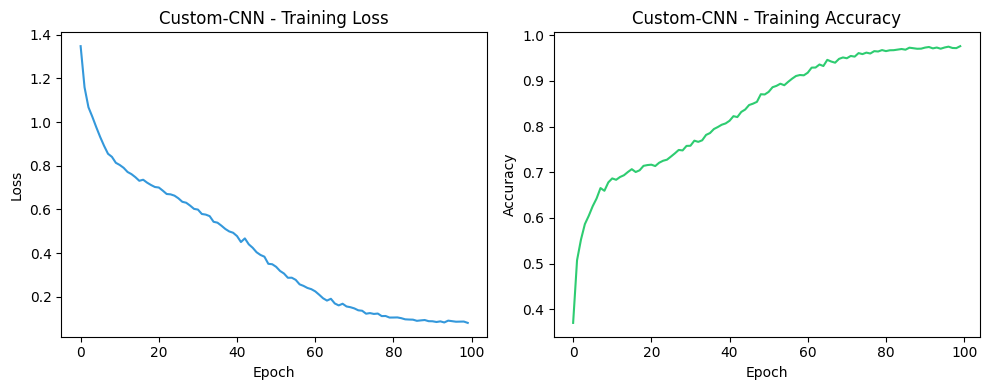


Evaluating on test set...



Test Accuracy: 0.9958
              precision    recall  f1-score   support

        Cyst       0.99      0.99      0.99       985
      Normal       1.00      1.00      1.00      1501
       Stone       0.99      1.00      0.99       863
       Tumor       1.00      1.00      1.00       685

    accuracy                           1.00      4034
   macro avg       1.00      1.00      1.00      4034
weighted avg       1.00      1.00      1.00      4034



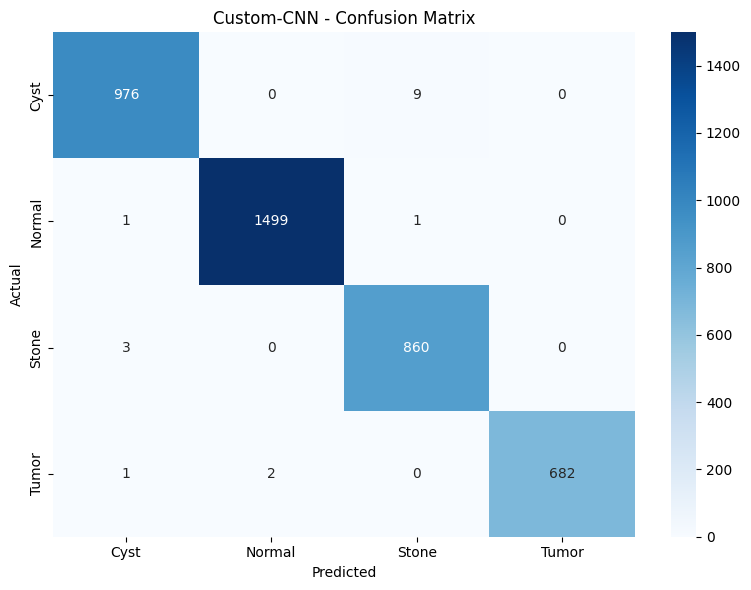

In [33]:
clear_gpu_memory()

custom_cnn_model = SimpleCNN(num_classes).to(device)
custom_cnn_results = train_model(custom_cnn_model, 'Custom-CNN', epochs=100, use_onecycle=True)

del custom_cnn_model
clear_gpu_memory()

---
## 9. Model Comparison

In [ ]:
# Collect all results
all_results = [
    efficientnet_results,
    resnet_results,
    densenet_results,
    custom_cnn_results
]

# Summary table
print("\n" + "="*70)
print("DEEP LEARNING MODELS - FINAL COMPARISON")
print("="*70)
print(f"{'Model':<20} {'Test Acc':>12} {'Trainable Params':>18} {'Epochs':>8}")
print("-"*70)

for r in all_results:
    print(f"{r['model_name']:<20} {r['test_accuracy']*100:>11.2f}% {r['trainable_params']:>18,} {r['epochs']:>8}")

print("-"*70)

# Find best model
best = max(all_results, key=lambda x: x['test_accuracy'])
print(f"\nBest Model: {best['model_name']} ({best['test_accuracy']*100:.2f}%)")


DEEP LEARNING MODELS - FINAL COMPARISON
Model                    Test Acc   Trainable Params   Epochs
----------------------------------------------------------------------
EfficientNet-B0            99.16%            328,964       20
ResNet-50                  97.42%            525,572       20
DenseNet-121               96.50%            263,428       20
Custom-CNN                 99.58%            390,404      100
----------------------------------------------------------------------

🏆 Best Model: Custom-CNN (99.58%)


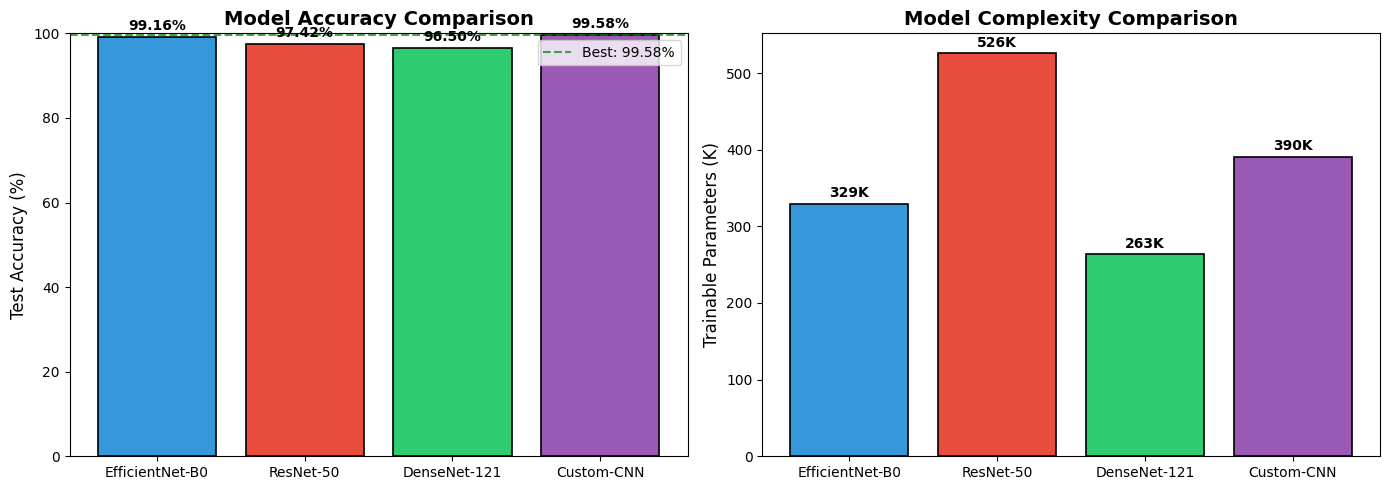

In [35]:
# Visualization: Model comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

model_names = [r['model_name'] for r in all_results]
accuracies = [r['test_accuracy'] * 100 for r in all_results]
params = [r['trainable_params'] for r in all_results]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

# Accuracy comparison
bars1 = ax1.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Test Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.axhline(y=max(accuracies), color='green', linestyle='--', alpha=0.7, label=f'Best: {max(accuracies):.2f}%')
ax1.legend()

for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

# Parameters comparison
bars2 = ax2.bar(model_names, [p/1000 for p in params], color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Trainable Parameters (K)', fontsize=12)
ax2.set_title('Model Complexity Comparison', fontsize=14, fontweight='bold')

for bar, p in zip(bars2, params):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             f'{p/1000:.0f}K', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_BASE, 'dl_model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Save combined results
combined_results = {
    'models': all_results,
    'best_model': best['model_name'],
    'best_accuracy': best['test_accuracy']
}

with open(os.path.join(OUTPUT_BASE, 'dl_results.json'), 'w') as f:
    json.dump(combined_results, f, indent=2)

print(f"Combined results saved to {os.path.join(OUTPUT_BASE, 'dl_results.json')}")
print("\nAll deep learning models trained and evaluated!")

Combined results saved to ../outputs\dl_combined_results.json

✓ All deep learning models trained and evaluated!
